<a href="https://colab.research.google.com/github/lamide-xxx/age-estimation-and-gender-classification/blob/main/age_gender_submit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You are supposed to train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be automated testing on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Average Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. make sure you have a stable internet connection.
2. double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [ ]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

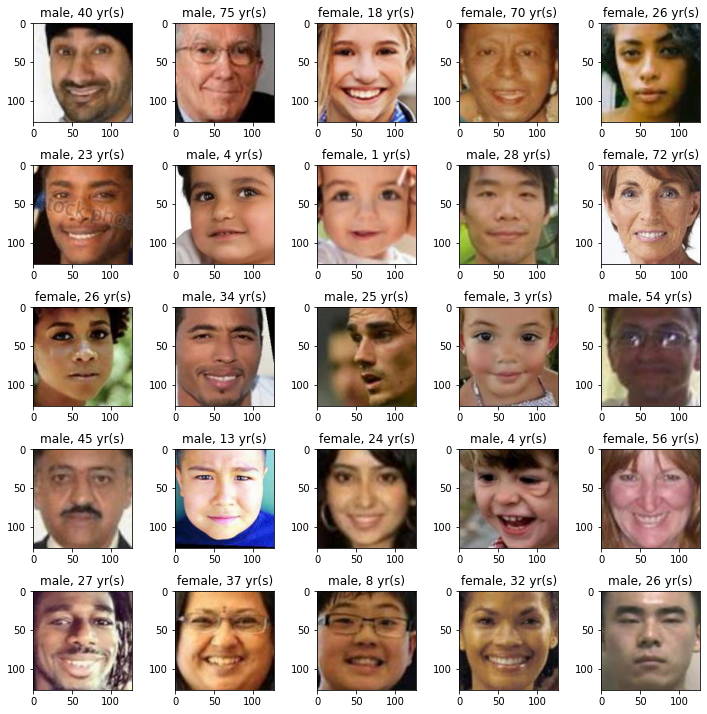

In [ ]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
folder = '/content/drive/MyDrive/Colab Notebooks/data/age-gender/train_val/'
plt.figure(figsize=(10,10))

i = 0 
for pic in os.listdir(folder): 
  if i<25:
    broken_filename = pic.split("_")

    #get the gender
    if broken_filename[1] == "0":
      gender = "male"
    else:
      gender = "female"

    plt.subplot(5,5,i+1,title = gender +", "+broken_filename[0] +" yr(s)")   
    
    filename = folder + pic #each picture's file path
    if not os.path.exists(filename):
      print ('No such file:'+filename)
    image = imread(filename)
    plt.imshow(image)
    i = i+1

  else:
    break

plt.tight_layout(pad = 1.0)   #Space out the images
 
plt.show()

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [ ]:
from itertools import groupby
from operator import itemgetter
import pandas as pd
import os, shutil

folder = '/content/drive/MyDrive/Colab Notebooks/data/age-gender/train_val/'
gdrive_dir = '/content/drive/MyDrive/Colab Notebooks'
original_dataset_dir = gdrive_dir+'/data/age-gender/train_val'

base_dir = gdrive_dir+'/data/age-gender/split-dataset'
if not os.path.exists(base_dir):
  os.mkdir(base_dir)

train_dir = os.path.join(base_dir,'train')
val_dir   = os.path.join(base_dir,'val')

# Training:Validation Data Split = 70:30 
n_train = 0.70
n_val = 0.30

all_filenames = sorted(os.listdir(folder))

#Create a ist of lists with processed filenames and their 
#respective indices in the all_filenames list
broken_filenames = [f.split("_") for f in all_filenames]
for elem in broken_filenames:
  elem.append(broken_filenames.index(elem))

results = []
for key, group in groupby(broken_filenames, lambda x: x[0]): #group by age
  results.append(list(group))

def split_data(data_path,split_ratio): 
    '''
    This function splits the data by copying the
    specified ratio of files from the source and
    pasting in the specified data_path.
    It returns a list of files in the newly formed data_set.
    ''' 
    os.mkdir(data_path)
    data_set = []
    gender = 0
    i = 0
    while (i < int(split_ratio * num_files)) and any(results):
      gender = (gender + 1) % 2  # toggle between genders
      for age_group in results:
        if i < round(int(split_ratio * num_files) / 10) *10:
          for img in age_group:
            if int(img[1]) == gender:
              image_index = img[-1]
              data_set.append(all_filenames[image_index])
              age_group.remove(img)
              i += 1
              break
    for fname in data_set:
      src = os.path.join(original_dataset_dir,fname)
      dst = os.path.join(data_path,fname)
      shutil.copyfile(src, dst)

    return data_set


if not os.path.exists(train_dir):
   train_set = split_data(train_dir,n_train)

if not os.path.exists(val_dir):   
  val_set = split_data(val_dir,n_val)


## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image
import cv2
def generate_df(dir):
  """
  This function creates a DataFrame containing filenames 
  of all images in the specified dir(ectory), along with
  the age and gender of each image. 
  It returns the created DataFrame
  """
  filenames = os.listdir(dir)
 
  records = []
  for pic in filenames:
    age, gender,_,_ = pic.split('_')
    records.append([int(gender),int(age)])

  df= pd.DataFrame(records)
  df['file'] = filenames
  df.columns = ['gender','age','filename']
  df = df.dropna()

  return df


def generate_data(data_dir, data_df, batch_size, is_training):
  '''
  This is a custom data generator which generates a batch of
  images when training/validating/testing a Model.
  '''
  images, ages, genders = [], [], []
  while True:
    for index,row in data_df.iterrows():
      age = row['age']
      gender = row['gender']
      filename = row['filename']
    
      pic = (cv2.imread(data_dir +'/'+ filename))
      pic = np.array(pic) / 255.0     #rescale pixel values

      ages.append(age)
      genders.append(gender)
      images.append(pic)
      
      if len(images) >= batch_size:# or (index == len(data_df) - 1):
        yield np.array(images), [np.array(genders),np.array(ages)]
      
    if not is_training:
      break



batch_size = 128

train_lb_df = generate_df(train_dir)
val_lb_df = generate_df(val_dir)

train_generator = generate_data(train_dir, train_lb_df,batch_size = batch_size, is_training = True)
val_generator = generate_data(val_dir, val_lb_df,batch_size = batch_size, is_training = True)


## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
3.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 42, 42, 32)   0           activation[0][0]                 
______________________________________________________________________________________________

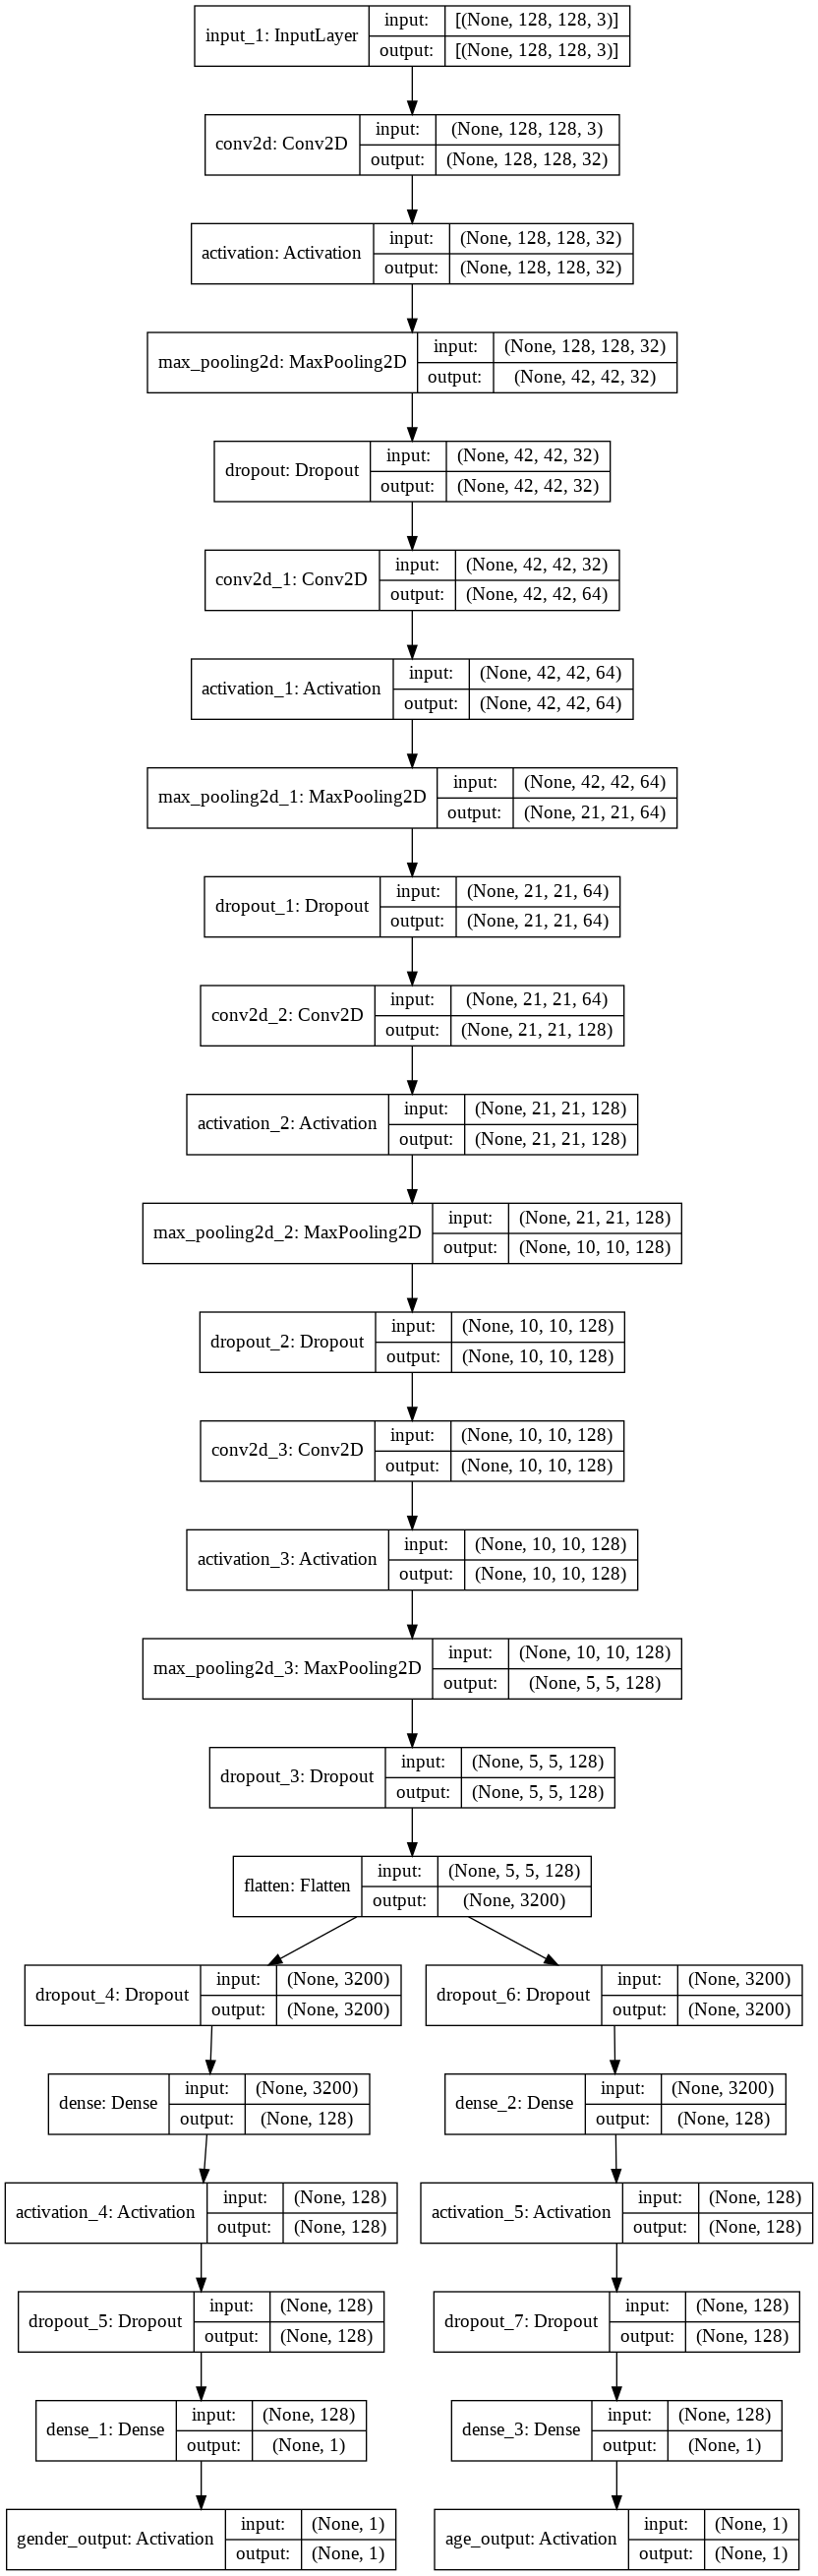

In [ ]:
from keras.models import Model
from keras.layers import Input, Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.regularizers import l2


class CNN_ModelA():
  """
  Used to generate a multi-output model. This CNN contains 
  two branches; one for age, other for gender. Each branch 
  shares the same convolutioinal base but contains its own
  sequence of Dense Layers.
  """

  def build_cov_net_layers(self, inputs):
    """
    Use to generate the Convolutional layers of the CNN Model.
    """
    x = Conv2D(32, (3, 3), padding="same", kernel_regularizer = l2(0.001))(inputs)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Dropout(0.1)(x)
    
    x = Conv2D(64, (3, 3), padding="same", kernel_regularizer = l2(0.001))(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)
    
    x = Conv2D(128, (3, 3), padding="same", kernel_regularizer = l2(0.001))(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)

    x = Conv2D(128, (3, 3), padding="same", kernel_regularizer = l2(0.01))(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)

    return x


  def build_age_branch(self, flattened):
    """
    Used to build the age branch of the network.
    """
    x = Dropout(0.4)(flattened)
    x = Dense(128, kernel_regularizer = l2(0.4))(x)
    x = Activation("relu")(x)
    x = Dropout(0.4)(x)
    x = Dense(1)(x)
    x = Activation("relu", name="age_output")(x)

    return x

  def build_gender_branch(self, flattened):
    """
    Used to build the gender branch of the network.
    """
    x = Dropout(0.4)(flattened)
    x = Dense(128, kernel_regularizer = l2(0.4))(x)
    x = Activation("relu")(x)
    x = Dropout(0.4)(x)
    x = Dense(1)(x)
    x = Activation("sigmoid", name="gender_output")(x)

    return x


  def assemble_model(self, im_height, im_width):
    """
    Used to assemble the multi-output model CNN
    """
    input_shape = (im_height,im_width,3)
    inputs = Input(shape = input_shape)

    #build the model
    cov_net = self.build_cov_net_layers(inputs)
    flatten = Flatten()(cov_net)
    gender_branch = self.build_gender_branch(flatten)
    age_branch = self.build_age_branch(flatten)
    

    model = Model(inputs = [inputs], outputs = [gender_branch,age_branch])

    return model



input_image_height = 128
input_image_width = 128

modelA = CNN_ModelA().assemble_model(input_image_height, input_image_width)

modelA.summary()
from keras.utils.vis_utils import plot_model
plot_model(modelA, show_shapes=True)

## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save_model(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by `modelA.load_model(model_folder+"age_gender_A.h5")`. 


In [ ]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

#Compile ModelA
modelA.compile(loss=["binary_crossentropy", "mse"],
            optimizer= 'adam',
            metrics={'gender_output':'accuracy', 'age_output':'mae'})

#Train ModelA
history = modelA.fit_generator(train_generator, 
                               steps_per_epoch = train_lb_df.shape[0] // batch_size,
                               epochs= 60, 
                               validation_data = val_generator , 
                               validation_steps = val_lb_df.shape[0] // batch_size)

your_model_folder = '/content/drive/MyDrive/Colab Notebooks/models/'
if not os.path.exists(your_model_folder):
    os.mkdir(your_model_folder)

modelA.save(your_model_folder+"age_gender_A.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
27/27 [==============================] - 26s 437ms/step - loss: 960.9670 - gender_output_loss: 0.7472 - age_output_loss: 811.3748 - gender_output_accuracy: 0.5059 - age_output_mae: 22.9648 - val_loss: 329.4467 - val_gender_output_loss: 0.6892 - val_age_output_loss: 267.0289 - val_gender_output_accuracy: 0.5113 - val_age_output_mae: 14.3065
Epoch 2/60
27/27 [==============================] - 12s 460ms/step - loss: 512.0713 - gender_output_loss: 0.6879 - age_output_loss: 458.1448 - gender_output_accuracy: 0.5483 - age_output_mae: 16.9987 - val_loss: 222.4605 - val_gender_output_loss: 0.6876 - val_age_output_loss: 181.8737 - val_gender_output_accuracy: 0.5223 - val_age_output_mae: 10.2815
Epoch 3/60
27/27 [==============================] - 13s 499ms/step - loss: 449.9751 - gender_output_loss: 0.6934 - age_output_loss: 411.1673 - gender_output_accuracy: 0.5205 - age_output_mae: 15.7916 - val_loss: 193.7874 - val_gender_output_loss: 0.6930 - val_age_output_loss: 159.1457 - val_ge

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


Text(0.5, 0, 'epoch')

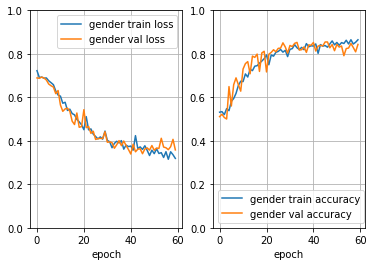

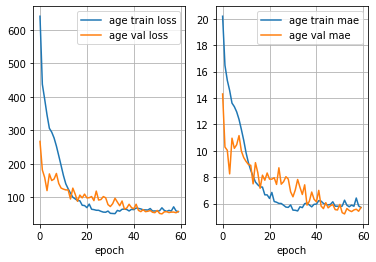

In [ ]:
import matplotlib.pyplot as plt

# Plot Model A Gender Output loss 
fig1 = plt.figure(1)
fig1.add_subplot(1,2,1)
plt.plot(history.history['gender_output_loss'], label='gender train loss')
plt.plot(history.history['val_gender_output_loss'], label='gender val loss')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.xlabel('epoch')

# Plot Model A Gender Output accuracy 
fig1.add_subplot(1,2,2)
plt.plot(history.history['gender_output_accuracy'], label='gender train accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label='gender val accuracy')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.xlabel('epoch')

# Plot Model A Age Output loss 
fig2 = plt.figure(2)
fig2.add_subplot(1,2,1)
plt.plot(history.history['age_output_loss'], label='age train loss')
plt.plot(history.history['val_age_output_loss'], label='age val loss')
plt.legend()
plt.grid(True)
#plt.ylim([0,1.0])
plt.xlabel('epoch')

# Plot Model A Age Output MAE 
fig2.add_subplot(1,2,2)
plt.plot(history.history['age_output_mae'], label='age train mae')
plt.plot(history.history['val_age_output_mae'], label='age val mae')
plt.legend()
plt.grid(True)
#plt.ylim([0,1.0])
plt.xlabel('epoch')



## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

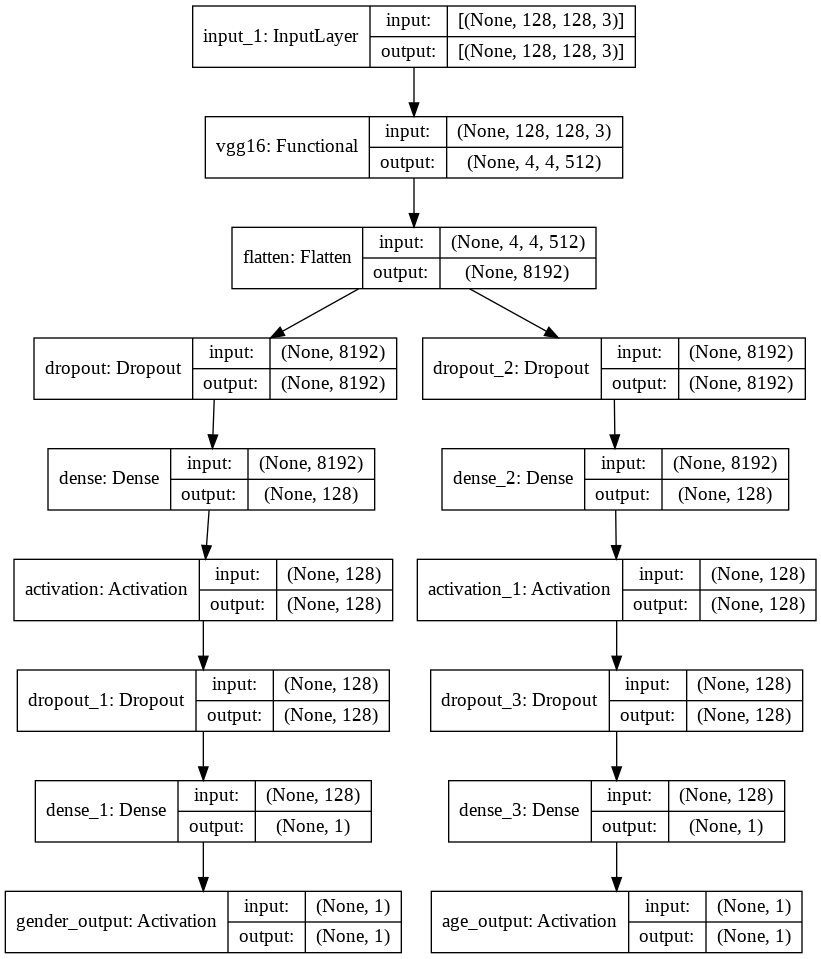

In [ ]:
#
# Add your code here
#
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Activation, Conv2D, MaxPooling2D, Dense, Flatten,Dropout
from keras.regularizers import l2

class CNN_ModelB():
  """
  Used to generate a multi-output model. This CNN contains 
  two branches; one for age, other for gender. Each branch 
  shares the same convolutioinal base but contains its own
  sequence of Dense Layers.
  """

  def build_cov_net_layers(self, input_image_width,input_image_height):
    """
    Use to generate the Convolutional base of the CNN Model.
    """

    # build the convolutional base of VGG16 network
    VGG16_conv_base = VGG16(weights = 'imagenet', 
                  include_top = False, # do not include the FC layers
                  input_shape = (input_image_height,input_image_width,3))

    # set all layers to non-trainable 
    for layer in VGG16_conv_base.layers:
        layer.trainable = False


    return VGG16_conv_base


  def build_age_branch(self, flattened):
    """
    Used to build the age branch of the network.
    """
    x = Dropout(0.4)(flattened)
    x = Dense(128, kernel_regularizer = l2(0.4))(x)
    x = Activation("relu")(x)
    x = Dropout(0.4)(x)
    x = Dense(1)(x)
    x = Activation("relu", name="age_output")(x)

    return x

  def build_gender_branch(self, flattened):
    """
    Used to build the gender branch of the network.
    """
    x = Dropout(0.4)(flattened)
    x = Dense(128, kernel_regularizer = l2(0.4))(x)
    x = Activation("relu")(x)
    x = Dropout(0.4)(x)
    x = Dense(1)(x)
    x = Activation("sigmoid", name="gender_output")(x)

    return x


  def assemble_model(self, im_height, im_width):
    """
    Used to assemble the multi-output model CNN
    """
    input_shape = (im_height,im_width,3)
    inputs = Input(shape = input_shape)

    #build the model
    output_VGG16 = (self.build_cov_net_layers(im_height, im_width))(inputs)
    flatten = Flatten()(output_VGG16) 
    gender_branch = self.build_gender_branch(flatten)
    age_branch = self.build_age_branch(flatten)
    

    model = Model(inputs = [inputs], outputs = [gender_branch,age_branch])

    return model

  

input_image_height = 128
input_image_width = 128

modelB = CNN_ModelB().assemble_model(input_image_height, input_image_width)

modelB.summary()
from keras.utils.vis_utils import plot_model
plot_model(modelB, show_shapes=True)

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [ ]:
#
# Add your code here
#
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

batch_size = 128

modelB.compile(loss=["binary_crossentropy", "mse"],
              optimizer= 'adam',
              metrics={'gender_output':'accuracy', 'age_output':'mae'})

historyB=modelB.fit(
        train_generator,
        steps_per_epoch= train_lb_df.shape[0] // batch_size,
        validation_data= val_generator, 
        epochs = 22,
        validation_steps= val_lb_df.shape[0]  // batch_size)

your_model_folder = '/content/drive/MyDrive/Colab Notebooks/models/'
if not os.path.exists(your_model_folder):
    os.mkdir(your_model_folder)

modelB.save(your_model_folder+"age_gender_B.h5")

Epoch 1/22
27/27 [==============================] - 132s 4s/step - loss: 756.9373 - gender_output_loss: 0.8016 - age_output_loss: 629.6750 - gender_output_accuracy: 0.5681 - age_output_mae: 19.6482 - val_loss: 141.2659 - val_gender_output_loss: 0.5075 - val_age_output_loss: 101.2006 - val_gender_output_accuracy: 0.7922 - val_age_output_mae: 7.7682
Epoch 2/22
27/27 [==============================] - 139s 5s/step - loss: 235.3383 - gender_output_loss: 0.4682 - age_output_loss: 195.8766 - gender_output_accuracy: 0.7891 - age_output_mae: 10.9169 - val_loss: 127.6524 - val_gender_output_loss: 0.4263 - val_age_output_loss: 89.5744 - val_gender_output_accuracy: 0.8433 - val_age_output_mae: 7.3069
Epoch 3/22
27/27 [==============================] - 160s 6s/step - loss: 162.8079 - gender_output_loss: 0.3970 - age_output_loss: 125.3428 - gender_output_accuracy: 0.8509 - age_output_mae: 8.5578 - val_loss: 121.1382 - val_gender_output_loss: 0.4441 - val_age_output_loss: 84.5552 - val_gender_output

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

Text(0.5, 0, 'epoch')

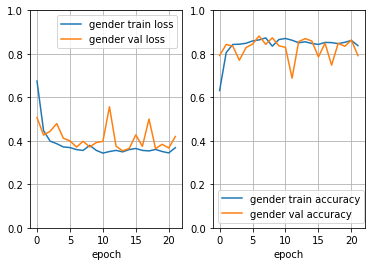

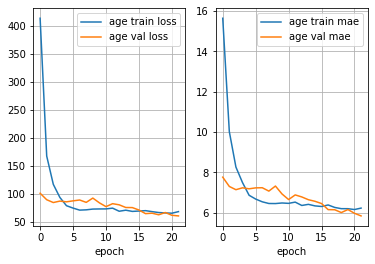

In [ ]:
import matplotlib.pyplot as plt

# Plot Model B Gender Output loss
fig1 = plt.figure(1)
fig1.add_subplot(1,2,1)
plt.plot(historyB.history['gender_output_loss'], label='gender train loss')
plt.plot(historyB.history['val_gender_output_loss'], label='gender val loss')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.xlabel('epoch')

# Plot Model B Gender Output accuracy
fig1.add_subplot(1,2,2)
plt.plot(historyB.history['gender_output_accuracy'], label='gender train accuracy')
plt.plot(historyB.history['val_gender_output_accuracy'], label='gender val accuracy')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.xlabel('epoch')

# Plot Model B Age Output loss
fig2 = plt.figure(2)
fig2.add_subplot(1,2,1)
plt.plot(historyB.history['age_output_loss'], label='age train loss')
plt.plot(historyB.history['val_age_output_loss'], label='age val loss')
plt.legend()
plt.grid(True)
#plt.ylim([0,1.0])
plt.xlabel('epoch')

# Plot Model B Age Output MAE
fig2.add_subplot(1,2,2)
plt.plot(historyB.history['age_output_mae'], label='age train mae')
plt.plot(historyB.history['val_age_output_mae'], label='age val mae')
plt.legend()
plt.grid(True)
#plt.ylim([0,1.0])
plt.xlabel('epoch')

## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Average Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#